## Machine Learning - Problem Set 2
#### 03/04/2024
### Aditya Narayan Rai (235843)

In [1]:
# First, let's import the important packages we are going to use for this assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Now let's load the dataset we are going to use for this assignment and define X and y
url = "https://raw.githubusercontent.com/grf-labs/grf/master/r-package/grf/vignettes/data/bruhn2016.csv"
df = pd.read_csv(url)
X = np.hstack((
    df["treatment"].values.reshape(-1, 1),
    df.iloc[:, 3:].values
))

y = df["outcome.test.score"].values

**Question 1:** Do some exploratory data analysis on the dataset. What do the variables look like? Is there missingness? What does the distribution of the outcome look like?

**Solution:**

In [3]:
# Now, let's check how the dataset looks like
print(df.shape)

(17299, 16)


In [4]:
# Now, let's check the first five rows of the dataset
df.head()

,outcome.test.score,treatment,school,is.female,mother.attended.secondary.school,father.attened.secondary.school,failed.at.least.one.school.year,family.receives.cash.transfer,has.computer.with.internet.at.home,is.unemployed,has.some.form.of.income,saves.money.for.future.purchases,intention.to.save.index,makes.list.of.expenses.every.month,negotiates.prices.or.payment.methods,financial.autonomy.index
0,47.367374,0,17018390,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,29.0,0.0,1.0,52.0
1,58.176758,1,33002614,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,41.0,0.0,0.0,27.0
2,56.671661,1,35002914,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,48.0,0.0,1.0,56.0
3,29.079376,0,35908915,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,27.0
4,49.563534,1,33047324,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,50.0,0.0,1.0,31.0


In [5]:
# Now, let's drop the 'school' variable, an identifier for schools
df = df.drop(columns=['school'])

In [6]:
# Now, let's check the descriptive stats of the variables
print(df.describe())

       outcome.test.score     treatment     is.female  \
count        17299.000000  17299.000000  15661.000000   
mean            58.415408      0.514134      0.556797   
std             14.735654      0.499815      0.496779   
min             22.316839      0.000000      0.000000   
25%             47.220957      0.000000      0.000000   
50%             58.822483      1.000000      1.000000   
75%             69.214005      1.000000      1.000000   
max            100.000000      1.000000      1.000000   

       mother.attended.secondary.school  father.attened.secondary.school  \
count                      15440.000000                     15350.000000   
mean                           0.429663                         0.394984   
std                            0.495044                         0.488863   
min                            0.000000                         0.000000   
25%                            0.000000                         0.000000   
50%                           

In [7]:
# Now, let's check for missing values in the dataset
print(df.isnull().sum())

outcome.test.score                         0
treatment                                  0
is.female                               1638
mother.attended.secondary.school        1859
father.attened.secondary.school         1949
failed.at.least.one.school.year         1913
family.receives.cash.transfer           1749
has.computer.with.internet.at.home      1877
is.unemployed                            789
has.some.form.of.income                  774
saves.money.for.future.purchases        1089
intention.to.save.index                 1903
makes.list.of.expenses.every.month       935
negotiates.prices.or.payment.methods    1062
financial.autonomy.index                1936
dtype: int64


There are quite a few missing values across the observations. Let's keep them as they are, since we will be using 'Simple Imputer' to work with them. It's also notable that there are no missing values in 'outcome.test.score' and 'treatment'.

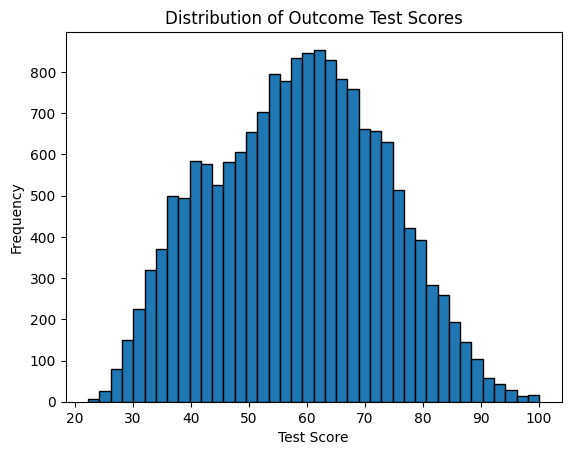

In [8]:
# Now let's check the distribution of the outcome variable
plt.hist(df['outcome.test.score'], bins=40, edgecolor='k')
plt.title('Distribution of Outcome Test Scores')
plt.xlabel('Test Score')
plt.ylabel('Frequency')
plt.show()

**Question 2:** Next, create your training and your test set. For this assignment, we are going to use almost the entire dataset as the **test** set: set aside 90% of the data for this test set. This will make your life easier as we iterate on models. By only training on a small fraction of the data, this process will be a lot faster. Assume that the data is i.i.d. for the purposes of this assignment, so you don't need to do anything special in splitting the data.

In the real world, you wouldn't want to have a split like this. It would be more common to have something like 30% of the data in the test set, but the size is usually determined by how accurately you need to know the error properties of your model.

**Solution:**

In [9]:
# Let's split the data into training and test sets using the already defined X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Let's check the size of each set to confirm the split
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 1729
Test set size: 15570


**Question 3:** The next task is to define how we're going to (1) impute missing data, (2) standardize the data and (3) fit the model.

Write a function that has just one argument: $regularization$ _ $strength$. This function should chain together your imputation strategy ($SimpleImputer$), your standardization strategy ($StandardScaler$) and the model class we want to estimate. In our case, that's $Ridge$ $Regression$! The way you create this chain is through what scikit-learn refers to as a "Pipeline". In particular, you should pass each of these instantiated objects into a call to $make$ _ $pipeline$. A function that just standardizes features and runs OLS would like the following:

    def create_ols_pipeline():
        return make_pipeline(
            StandardScaler(),
            LinearRegression()
        )

You may be asking why we're going to the trouble to construct this complicated object instead of just doing it step-by-step by hand. The reason is that we're going to be doing cross-validation, and this vastly simplifies the amout of code you'll need to write, while ensuring sure that you always respect the training/validation split.

**Solution:**

In [24]:
def create_ridge_pipeline(regularization_strength):
    """
    Creates a pipeline that imputes missing data, standardizes the data, 
    and fits a Ridge Regression model.
    
    Parameters:
    - regularization_strength: The regularization strength (alpha) for Ridge Regression.
    
    Returns:
    - A scikit-learn pipeline object that can be used to fit data and make predictions.
    """
    return make_pipeline(
        SimpleImputer(missing_values = np.nan, strategy='most_frequent'),
        StandardScaler(),
        Ridge(alpha=regularization_strength)
    )

**Question 4:** Using the pipeline you created, fit a ridge regression where the regularization parameter is $alpha$ = 0.1 on the (entire) training set.

Fitting and predicting with this pipeline works exactly the same as if you had directly instantiated a $Ridge$ model directly (i.e. the $fit$() and $predict$() methods work just the same.)

**Solution:**

In [25]:
# Let's create the pipeline with alpha = 0.1
ridge_pipeline = create_ridge_pipeline(0.1)

# Now, let's fFit the pipeline on the entire training set
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

**Question 5:** Use the $KFold$ class to construct a set of 10 folds to be used for cross-validation.

We create this ahead of time because we want to use the exact same folds for every value of the hyperparameters (and every model) that we test so that we compare them, apples to apples.

In [26]:
# Let's create a set of 10 folds to be used for cross-validation
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

**Question 6:** Using the training data, use cross-validation to choose a good value of the regularization parameter. You should:

- Try a range of different values (e.g. 20 values between $10^{-6}$ and $10^{6}$) and inspect the estimand mean squared error. You'll want to choose values in a log-spaced grid (i.e. powers of 10). You can do this using numpy's $logspace$ function, e.g. $np.logspace(-6, 6, num = 10, base = 10)$.
- Plot the MSE for each value, along with standard errors.

It might help you to use the $cross_val_score$ function. The following code shows you how to use this function on a model/pipeline named 'model', for features called 'X' and labels called 'y', with a cross-validation object (e.g. created by KFold) called 'cv' and defining a 'scoring' function from the mean squared error:

    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error, make_scorer
    cross_val_score(mode, X, y, cv=cv, scoring = make_scorer(mean_squared_error))

This will return a numpy array with one error estimate for each fold of CV. You can then calculate the average (to get the overall CV estimate of MSE) or the standard error. Since you have 10 folds of CV, you will have 10 MSE estimates for each vale of the regularization parameter you pick. Calculate the standard error as $np.std(mses) / np.sqrt(mses.shape[0])$.

**Solution:**

In [27]:
# Let's select a range of 20 alphas
alpha_values = np.logspace(-6, 6, num = 20, base = 10)

# And, also check the values of alphas
print(alpha_values)

[1.00000000e-06 4.28133240e-06 1.83298071e-05 7.84759970e-05
 3.35981829e-04 1.43844989e-03 6.15848211e-03 2.63665090e-02
 1.12883789e-01 4.83293024e-01 2.06913808e+00 8.85866790e+00
 3.79269019e+01 1.62377674e+02 6.95192796e+02 2.97635144e+03
 1.27427499e+04 5.45559478e+04 2.33572147e+05 1.00000000e+06]


In [28]:
# Now let's create the dictionaries to store the values
mean_mse_ridge = []
stderr_mse_ridge = []

# Now let's loop through each vale of the alpha and perform the cross-validation
for alpha in alpha_values:
    ridge_pipeline = create_ridge_pipeline(alpha)
    cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, 
                                scoring='neg_mean_squared_error', cv=kf)
    
    # Convert scores to positive MSE values for reporting
    mean_mse_ridge.append(-1 * np.mean(cv_scores))
    # Standard error calculation for each alpha's MSE across folds
    stderr_mse_ridge.append(np.std(cv_scores) / np.sqrt(len(cv_scores)))

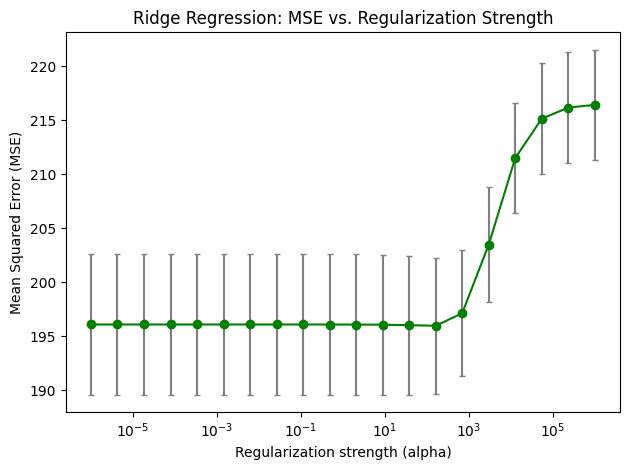

In [29]:
# Let's plot the MSE for each value, along with the standard errors
plt.errorbar(alpha_values, mean_mse_ridge, yerr=stderr_mse_ridge, fmt='-o', 
             color = 'green', ecolor = 'gray', capsize = 2)
plt.xscale('log')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Ridge Regression: MSE vs. Regularization Strength')
plt.tight_layout()
plt.show()

**Question 7:** Point out which value of the regularization parameter (and therefore which model) you would choose to use based on these results, using the one-standard-error rule we discussed in class.

**Solution:**

In [30]:
# Let's find the model with the lowest MSE
min_mse_index = np.argmin(mean_mse_ridge)
min_mse = mean_mse_ridge[min_mse_index]
min_mse_stderr = stderr_mse_ridge[min_mse_index]

# Let's apply the one-standard error rule
within_one_std = min_mse + min_mse_stderr

candidate_alphas = [alpha_values[i] for i, mse in enumerate(mean_mse_ridge) 
                    if mse <= within_one_std]

best_alpha_ridge = max(candidate_alphas)

print("candidate_alphas",candidate_alphas)
print(f"Best alpha using the one-standard-error rule: {best_alpha_ridge}")

candidate_alphas [1e-06, 4.281332398719396e-06, 1.8329807108324375e-05, 7.847599703514606e-05, 0.0003359818286283781, 0.0014384498882876629, 0.00615848211066026, 0.026366508987303555, 0.11288378916846883, 0.4832930238571752, 2.06913808111479, 8.858667904100814, 37.92690190732246, 162.37767391887175, 695.1927961775591]
Best alpha using the one-standard-error rule: 695.1927961775591


So, we'll pick a value for $\alpha$ that's a little higher than 695. We'll do this by choosing the biggest $\alpha$ that has an mean squared error close to the $\alpha$ that has the lowest MSE, but within one standard error.

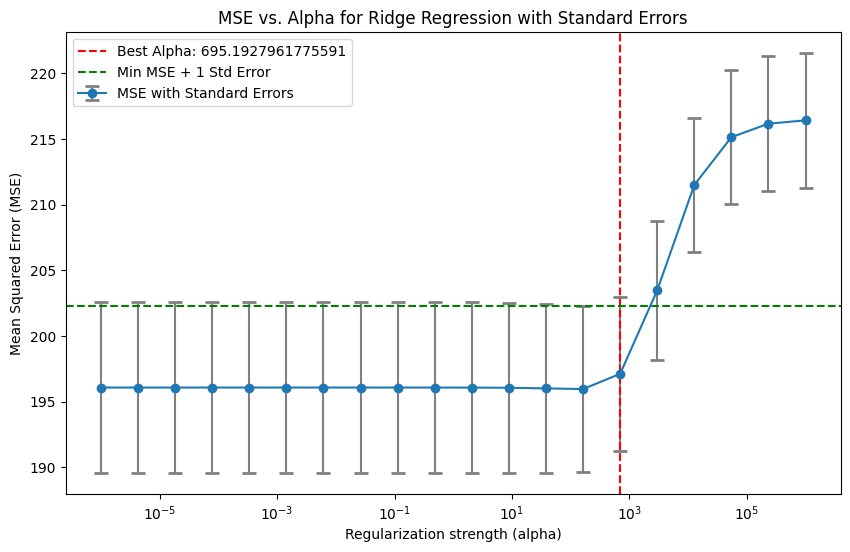

In [31]:
plt.figure(figsize=(10, 6))

# Plotting MSE vs Alpha with standard error bars
plt.errorbar(alpha_values, mean_mse_ridge, yerr=stderr_mse_ridge, fmt='-o', 
             ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Highlighting the best alpha according to the one-standard-error rule with a vertical line
plt.axvline(x=best_alpha_ridge, color='red', linestyle='--', label=f'Best Alpha: {best_alpha_ridge}')

# Adding a horizontal line for one standard error above the minimum MSE
plt.axhline(y=within_one_std, color='green', linestyle='--', label='Min MSE + 1 Std Error')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xscale('log')  # Alpha values are on a logarithmic scale
plt.title('MSE vs. Alpha for Ridge Regression with Standard Errors')
plt.legend()

plt.show()

**Question 8:** Next create a new version of your function from Question 3 which replaces ridge regression with $KernelRidge$. You will need to add a second argument to the function as well to indicate the "lengthscale". This is the parameter that determines the width of the region near a test point which should have positive weight. To instantiate a Kernel Ridge Regression in scikit-learn, you'd do the following:

    KernelRidge(alpha = 0.01, kernel = "rbf", gamma = 1)

where the gamma denotes the lengthscale. For more context: scikit-learn uses some weird terminology, but it's all the same mechanics that we've talked about in class. An 'rbf' kernel (radial basis function kernel) is the same idea as a Gaussian kernel. The developers of scikit-learn define this RBF kernel to be $\exp\left(-\gamma||x - x'||^2\right)$. This is identical to a Gaussian kernel when $\gamma = \frac{1}{2\sigma^2}$. This difference in how they encode the kernel means that a larger gamma parameter corresponds to a smaller region in which two points are considered similar. Contrast this to $\sigma^2$, in which larger $\sigma^2$ corresponds to a larger region of "nearby" points. The difference in terminology is confusing, but the main point is that there is a one to one mapping between values of gamma and values of $\sigma^2$. We're going to search over a range of values of gamma to see what works best regardless, so it's primarily an issue of interpretation.

**Solution:**

In [32]:
def create_kernel_ridge_pipeline(regularization_strength, lengthscale):
    """
    Creates a pipeline that imputes missing data, standardizes the data, 
    and fits a KernelRidge model.
    
    Parameters:
    - regularization_strength: The regularization strength (alpha) for Ridge Regression.
    - lengthscale: It determines the width of the region near a test point which should have positive weight
    
    Returns:
    - A scikit-learn pipeline object that can be used to fit data and make predictions.
    """
    return make_pipeline(
        SimpleImputer(missing_values = np.nan, strategy='most_frequent'),
        StandardScaler(),
        KernelRidge(alpha = regularization_strength, kernel = "rbf", gamma = lengthscale)
    )

**Question 9:** Find the cross-validated MSE for a range of values of gamma, e.g. 10 values between $10^{-7}$ and $10^{-1}$ (again, on a log-space grid). Do this for one fixed level of the regularization parameter. You can set $alpha = 0.1$ or whatever you found optimal for ridge regression in Question 7.

**Solution:**

In [33]:
# Let's define the range of gamma values
gamma_values = np.logspace(-7, -1, num = 10)

# Now, let's create the disctionaries to store the values
mean_mse_kernel = []
stderr_mse_kernel = []

# Let's use the optimal aplha found previously
optimal_alpha = best_alpha_ridge

for gamma in gamma_values:
    # First create the pipeline with the current gamma and optimal alpha
    kernel_pipeline = create_kernel_ridge_pipeline(optimal_alpha, gamma)
    
    # Let's perform the cross-validation
    cv_scores = cross_val_score(kernel_pipeline, X_train, y_train, 
                                scoring = "neg_mean_squared_error", cv=10)
    
    # Finally let's convert scores to positive MSE values and compute the statistics
    mean_mse_kernel.append(-1 * np.mean(cv_scores))
    stderr_mse_kernel.append(np.std(cv_scores) / np.sqrt(len(cv_scores)))

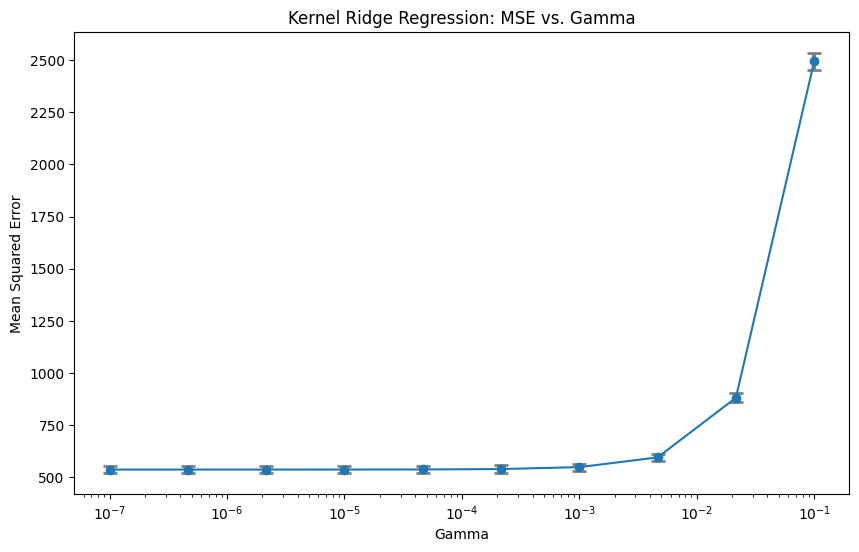

In [34]:
plt.figure(figsize=(10, 6))
plt.errorbar(gamma_values, mean_mse_kernel, yerr=stderr_mse_kernel, fmt='-o', 
             ecolor='gray', elinewidth=3, capsize=5, capthick=2, label='MSE with Standard Errors')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error')
plt.title('Kernel Ridge Regression: MSE vs. Gamma')
plt.show()

In [36]:
# Let's find the model with the lowest MSE
min_mse_index_kernel = np.argmin(mean_mse_kernel)
min_mse_kernel = mean_mse_kernel[min_mse_index_kernel]
min_mse_stderr_kernel = stderr_mse_kernel[min_mse_index_kernel]

# Let's apply the one-standard error rule
within_one_std_kernel = min_mse_kernel + min_mse_stderr_kernel

candidate_gammas = [gamma_values[i] for i, mse in enumerate(mean_mse_kernel) 
                    if mse <= within_one_std_kernel]

best_gamma_kernel = max(candidate_gammas)

print("Candidate gammas within one standard error of the minimum MSE:",candidate_gammas)
print(f"Best gamma using the one-standard-error rule: {best_gamma_kernel}")

print(min_mse_kernel)
print(min_mse_stderr_kernel)

Candidate gammas within one standard error of the minimum MSE: [1e-07, 4.641588833612782e-07, 2.1544346900318822e-06, 1e-05, 4.641588833612772e-05, 0.00021544346900318823, 0.001]
Best gamma using the one-standard-error rule: 0.001
537.6557443007832
17.03390043125213


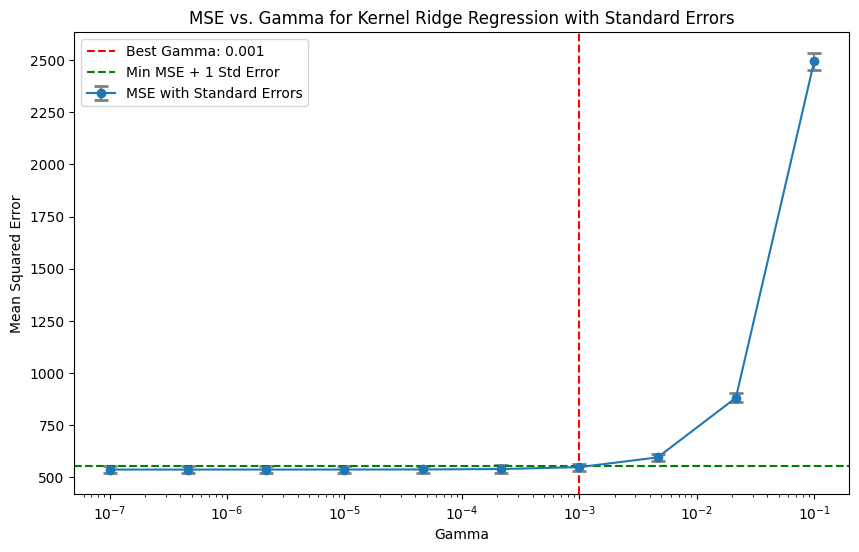

In [37]:
plt.figure(figsize=(10, 6))

# Plotting MSE vs Gamma with standard error bars for Kernel Ridge Regression
plt.errorbar(gamma_values, mean_mse_kernel, yerr=stderr_mse_kernel, fmt='-o', 
             ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Highlighting the best gamma according to the one-standard-error rule with a vertical line
plt.axvline(x=best_gamma_kernel, color='red', linestyle='--', label=f'Best Gamma: {best_gamma_kernel}')

# Adding a horizontal line for one standard error above the minimum MSE for Kernel Ridge
min_mse_plus_se_kernel = min_mse_kernel + min_mse_stderr_kernel 
plt.axhline(y=min_mse_plus_se_kernel, color='green', linestyle='--', label='Min MSE + 1 Std Error')

plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error')
plt.xscale('log')  # Gamma values are on a logarithmic scale
plt.title('MSE vs. Gamma for Kernel Ridge Regression with Standard Errors')
plt.legend(loc='best')

plt.show()

**Question 10:** Calclulate the error in the test set for both your best $Ridge$ and $KernelRidge$ model. Which is better?

**Solution:**

In [38]:
# Let's train the Ridge model with the best alpha
ridge_model = create_ridge_pipeline(best_alpha_ridge).fit(X_train, y_train)

# Now, let's train the KernelRidge model with the best alpha and gamma
kernel_ridge_model = create_kernel_ridge_pipeline(optimal_alpha, best_gamma_kernel).fit(X_train, y_train)

# Let's predict and calculate MSE for Ridge
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

# And now, let's predict and calculate MSE for KernelRidge
kernel_ridge_predictions = kernel_ridge_model.predict(X_test)
kernel_ridge_mse = mean_squared_error(y_test, kernel_ridge_predictions)

print(f"Ridge MSE: {ridge_mse}")
print(f"KernelRidge MSE: {kernel_ridge_mse}")

# Finally, let's determine which model is better
if ridge_mse < kernel_ridge_mse:
    print("Ridge model performs better on the test set.")
else:
    print("KernelRidge model performs better on the test set.")

Ridge MSE: 194.62256032466283
KernelRidge MSE: 517.5722277069775
Ridge model performs better on the test set.


**Question 11:** It turns out that the way that students were assigned to treatment was not actually i.i.d. Rather, the *high school* was assigned into treatment. This was done out of a concern that the outcomes between students might be correlated within schools.

Using this fact, and what we talked about at the beginning of lecture 4 about reasons we might want to split data into folds for cross-validation differently than a naive, completely random split, what might you do differently in the cross-validation process to account for this dependency structure? You don't need to actually do it, just describe what you would do differently.

**Solution:**

To address the issue of students being grouped by high school, which can affect the outcomes, I would use a grouped cross-validation approach, such as Scikit-learn's **GroupKFold**. This ensures that all students from the same school are assigned to either the training set or the validation set, but not split across both.

***Note to the Prof:*** I used the lab 6 notes and ChatGPT for understanding and implementing some parts of this assignment.